## AdaBoost Using Gradient Boosting Framework

This is an attempt to implement toy Gradient Boosting Machine from scratch. Algorithm used is:
<img src="GBM.jpg" />
This has been taken from the book Elements of Statistical Learning, Second Edition by Tibshirani, Hastie and Friedman

To implement AdaBoost within GBM framework, we need to calculate three parameters in the GBM algorithm: $f_{0}(x)$, $r_{im}$ and $\gamma_{im}$. To derive these values we will use the following modified exponential loss function:

$$ L(y_{i},f(x)) =\sum e^{-(2y_{i} - 1)f(x_{i})} $$ 

Results are:

$$f_{0}(x) = \frac{1}{2} \log \frac{\sum y_{i}}{\sum (1 - y_{i})} $$

$$ r_{im} = -(2y_{i} - 1)2e^{-(2y_{i} - 1)f(x_{i})}$$

$$\gamma_{jm} = \frac{\sum_{x_{i} \in R_{jm}} (2y_{i} - 1)e^{-(2y_{i} - 1)f(x_{i})}}{\sum_{x_{i} \in R_{jm}} e^{-(2y_{i} - 1)f(x_{i})}}$$

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_gaussian_quantiles
import copy
import numpy as np
%matplotlib inline
import random
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")
import csv
import math

In [2]:
def MSE(Data):
    
    #This equation is according to equation 9.12 page 307 of ESL Second Edition
    
    Var = sum((Data[:,2] - np.mean(Data[:,2]))*(Data[:,2] - np.mean(Data[:,2])))
    
    return Var

In [3]:
def InformationGain(Threshold,Data,Feature):
    
    DataL=Data[np.where(Data[:,Feature]>=Threshold)]
    DataR=Data[np.where(Data[:,Feature]<Threshold)]
    
    H_all = MSE(Data)
    
    H_L = MSE(DataL)
    
    H_R = MSE(DataR)

    return H_L + H_R

In [4]:
def GetBestFeature(Data):
        
    Feature1 = []
    
    Feature2 = []
    
    Feature1ThresholdList = np.sort(Data[:,0])
    Feature2ThresholdList = np.sort(Data[:,1])
    
    for k in range(1,len(Data)-1):
            
        InfoGainFeat_1 = InformationGain((Feature1ThresholdList[k-1]+Feature1ThresholdList[k])/2,Data,0)
        InfoGainFeat_2  = InformationGain((Feature2ThresholdList[k-1]+Feature2ThresholdList[k])/2,Data,1)
        
        Feature1.append([InfoGainFeat_1,(Feature1ThresholdList[k-1]+Feature1ThresholdList[k])/2])
        Feature2.append([InfoGainFeat_2,(Feature2ThresholdList[k-1]+Feature2ThresholdList[k])/2])
       
    Feature1 = np.vstack(Feature1)
    Feature2 = np.vstack(Feature2)
    
    BestThresholdFeat_1, ThresholdIndex1 = min(Feature1[:,0]), np.argmin(Feature1[:,0])
    BestThresholdFeat_2, ThresholdIndex2 = min(Feature2[:,0]), np.argmin(Feature2[:,0])

    #When there is a conflict between two features,
    #that is information gain for both are equal,
    #then we randomly select one
    if BestThresholdFeat_1==BestThresholdFeat_2:
        if np.random.choice(2,1)[0]==0:
            return 0,Feature1[ThresholdIndex1,1]   
        else:
            return 1,Feature2[ThresholdIndex2,1]
    elif BestThresholdFeat_1 < BestThresholdFeat_2:
        return 0, Feature1[ThresholdIndex1,1]
    else:
        return 1, Feature2[ThresholdIndex2,1]
    

In [20]:
def CreateStump(BestFeature, SplittingThreshold, FullData):
    
    LeftChildData = FullData[np.where(FullData[:,BestFeature]>=SplittingThreshold)]
    RightChildData = FullData[np.where(FullData[:,BestFeature]<SplittingThreshold)]
    
    LeftChildMean = np.mean(LeftChildData[:,2])
    RightChildMean = np.mean(RightChildData[:,2])
    
    return {'Feature':BestFeature, 'Split':SplittingThreshold, 'LeftChildPred':LeftChildMean, 'RightChildPred':RightChildMean, 'LeftGamma':1, 'RightGamma':1}

In [6]:
def AddGamma(Learner,Gamma):
    
    
    Learner['LeftGamma'] = Gamma[0][1]
    
    Learner['RightGamma'] = Gamma[1][1]
    

In [10]:
def classify(Data,Tree,Type):
     
    if Data[Tree['Feature']] >= Tree['Split']:
        if Type == 'Loop':
            return Tree['LeftChildPred']
        else:
            return Tree['LeftGamma']*Tree['LeftChildPred']
    else:
        if Type == 'Loop':
            return Tree['RightChildPred']
        else:
            return Tree['RightGamma']*Tree['RightChildPred']

In [11]:
def _DecisionTreeRegressor(Data):
    
    BestFeature, SplittingThreshold = GetBestFeature(Data)
    
    Tree = CreateStump(BestFeature, SplittingThreshold, Data)
    
    return Tree

In [27]:
def GBM(DataInput,depth,maxdepth,M,SamplePercent):
    
    # create list of learners
    LearnerList = []
    GammaList = []
    
    
    Data=copy.deepcopy(DataInput)
    
    # concatenate two columns
    # Final structure of the data:
    # Col 1: X1 (feature 1)
    # Col 2: X2 (feature 2)
    # Col 3: Residuals
    # Col 4: "boost" achieved at each step
    # Col 5: Y (class value)

    Data=np.c_[Data[:,0],Data[:,1],np.array([1/len(Data)]*(len(Data))),np.array([(1/2)*np.log(sum(Data[:,2])/sum(1-Data[:,2]))]*(len(Data))),Data[:,2]]
    
    for m in range(0,M):
        
        # select random rows, based on the "SamplePercent" Value: SamplePercent = 0 to 100
        RandomSelectedAxes = np.random.choice(Data.shape[0], int((len(Data))*(SamplePercent/100)), replace=False)
        
        # Calculate residual
        Data[RandomSelectedAxes,2] = -1.0*(2*Data[RandomSelectedAxes,4]-1)*np.exp(-1.0*(2*Data[RandomSelectedAxes,4]-1)*Data[RandomSelectedAxes,3])

        # Fit a regression tree to the residuals
        Learner = _DecisionTreeRegressor(Data)
        
        # Get prediction for each example
        Prediction = []
        for row in Data:
            Prediction.append(classify(row,Learner,'Loop'))
        
        Prediction = np.array(Prediction)
    
        # Get unique Regions R1, R2... Rn
        UniquePredictions = np.unique(Prediction)
        
        # Calculate gamma for each Region
        Gamma = []
    

        for UqPred in UniquePredictions:
            
            _y = 2*Data[np.where(Prediction==UqPred)][:,4]-1
            W = 1
            fx = Data[np.where(Prediction==UqPred)][:,3]

    
            Numerator = sum(_y*W*np.exp(-1*_y*fx))
            Denominator = sum(W*np.exp(-1*_y*fx))
            
            if abs(Denominator) < 1e-150:
                Ratio = 0.0
            else:
                Ratio = Numerator/Denominator
            Gamma.append([UqPred,Ratio])

        Gamma=np.array(Gamma)
        
        # Update learner value for each data point
        for k in range(len (Data)):
            Data[k,3]=Data[k,3]+Gamma[Gamma[:,0]==Prediction[k],1]
            
        #AddGamma(Learner, Gamma)        
        
        # Append the learner at this stage to the learner list
        LearnerList.append(Learner)
        GammaList.append(Gamma)
        
    return LearnerList

In [44]:
def plot(data,learners):
    xx = np.linspace(min(data[:,0])-0.1, max(data[:,0])+0.1, 30)
    yy = np.linspace(min(data[:,1])-0.1, max(data[:,1])+0.1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)

    pred=[0]*len(xy)
    pred=np.array(pred)
    Threshold=[0]*len(xy)

    for i in range(0,len(xy)):
        for tree_model in learners:
            Threshold[i]=Threshold[i]+classify(xy[i,:].reshape(1,-1)[0],tree_model,'Ensemble')

        if Threshold[i]>=0:
            pred[i]=1
        else:
            pred[i]=0
    
    Z=pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.show()

### Simulated data 1:


In [34]:
X,Y = make_circles(n_samples=100,noise=0.2, factor=0.5, random_state=1)
Data = np.append(X,Y.reshape(-1,1),axis=1)

#### Single decision stump

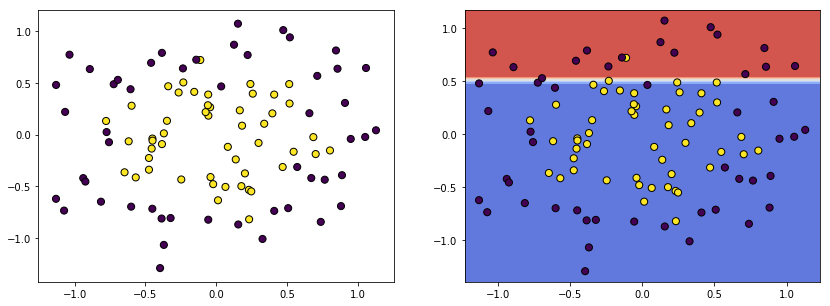

In [48]:
M = 1
Model = GBM(np.copy(data),0,1,M,100)
plot(Data, Model)

#### Boosted ensemble

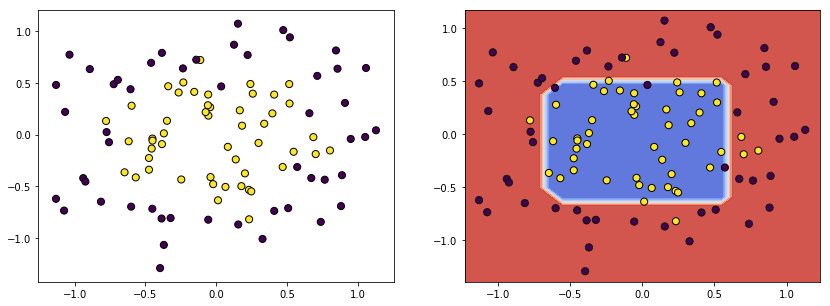

In [49]:
M=10
learners=GBM(np.copy(Data),0,1,M,100)
plot(Data,learners)

### Simulated data 2

In [50]:
X,Y=make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=100)
Data=np.append(X,Y.reshape(-1,1),axis=1)

#### Single decision tree

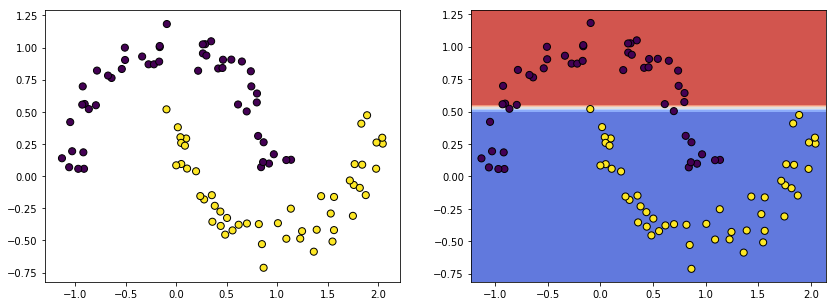

In [52]:
M = 1
learners = GBM(copy.deepcopy(Data),0,1,M,100)
plot(Data,learners)

#### Boosted ensemble

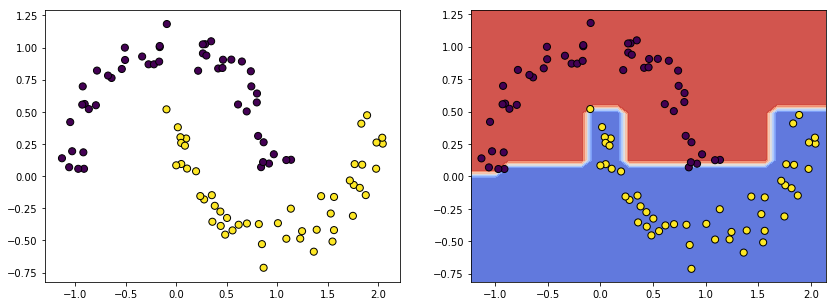

In [53]:
M = 50
learners = GBM(copy.deepcopy(Data),0,1,M,100)
plot(Data,learners)

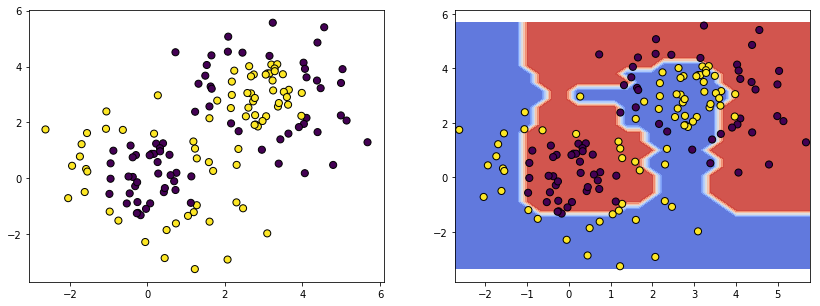

In [381]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=75, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=75, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
Y = np.concatenate((y1, - y2 + 1))

data=np.append(X,Y.reshape(-1,1),axis=1)

M=50
learners=GBM(copy.deepcopy(data),0,1,M,100)
plot(data,learners)

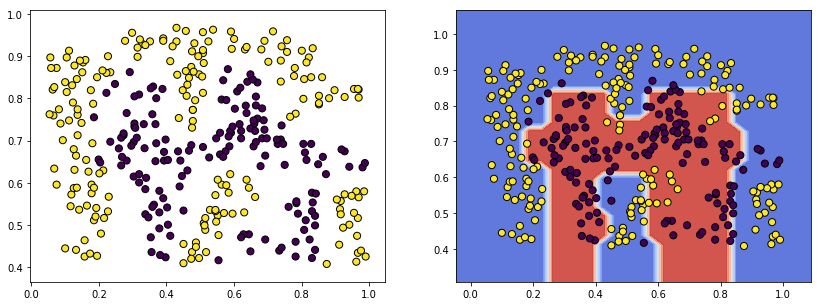

In [397]:
data_2=[]
with open("ex8a.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_2.append(row)
    f.close()
    
data_2=np.array(np.vstack(data_2))
data=np.ndarray.astype(data_2,float)

RandomSelectedAxes=np.random.choice(data.shape[0], int((len(data))*(40/100)), replace=False)
data=data[RandomSelectedAxes,:]

M=40
learners=GBM(copy.deepcopy(data),0,1,M,100)
plot(data,learners)